In [2]:
import pandas as pd
import numpy as np
import talib as ta
import pyupbit as up
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = up.get_ohlcv(ticker="KRW-BTC", interval="day", count=2210)
df.to_csv('bitcoin_data.csv')

In [11]:
df = pd.read_csv('bitcoin_data.csv')
df

,Unnamed: 0,open,high,low,close,volume,value
0,2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
1,2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
2,2017-09-30 09:00:00,4657000.0,4896000.0,4651000.0,4895000.0,19.998483,9.561476e+07
3,2017-10-01 09:00:00,4889000.0,4978000.0,4682000.0,4962000.0,27.323332,1.331325e+08
4,2017-10-02 09:00:00,4962000.0,5095000.0,4956000.0,5025000.0,31.728004,1.599315e+08
...,...,...,...,...,...,...,...
2205,2023-10-12 09:00:00,36671000.0,36880000.0,36408000.0,36750000.0,1763.265496,6.450338e+10
2206,2023-10-13 09:00:00,36750000.0,37193000.0,36724000.0,36968000.0,1756.990238,6.484151e+10
2207,2023-10-14 09:00:00,36968000.0,37156000.0,36700000.0,36790000.0,1222.065339,4.515127e+10
2208,2023-10-15 09:00:00,36790000.0,37189000.0,36659000.0,37086000.0,1648.567710,6.073250e+10


In [12]:
df_data = pd.DataFrame()
df_data['Close'] = df['close']

# 이동평균
df_data['MA5'] = ta.SMA(df['close'], timeperiod=5)
df_data['MA20'] = ta.SMA(df['close'], timeperiod=20)

# RSI
df_data['RSI'] = ta.RSI(df['close'], timeperiod=14)

# MACD
df_data['MACD'], df_data['Siganl'], df_data['Hist'] = ta.MACD(df['close'], fastperiod=12, 
                                                          slowperiod=26, signalperiod=9)

# 볼린저 밴드
df_data['Upper'], df_data['Middle'], df_data['Lower'] = ta.BBANDS(df['close'], timeperiod=20, 
                                                               nbdevup=2, nbdevdn=2)

# 스토캐스틱
df_data['SlowK'], df_data['SlowD'] = ta.STOCH(df['high'], df['low'], df['close'], 
                                              fastk_period=5, slowk_period=3, slowd_period=3)

# OBV
df_data['OBV'] = ta.OBV(df['close'], df['volume'])

# ADX
df_data['ADX'] = ta.ADX(df['high'], df['low'], df['close'])

# ATR
df_data['ATR'] = ta.ATR(df['high'], df['low'], df['close'])

# MFI
df_data['MFI'] = ta.MFI(df['high'], df['low'], df['close'], df['volume'], timeperiod=14)

# ROC
df_data['ROC'] = ta.ROC(df['close'], timeperiod=10)

# CCI
df_data['CCI'] = ta.CCI(df['high'], df['low'], df['close'], timeperiod=20)

# DMI
df_data['DMI+'] = ta.PLUS_DI(df['high'], df['low'], df['close'], timeperiod=14)
df_data['DMI-'] = ta.MINUS_DI(df['high'], df['low'], df['close'], timeperiod=14)

df_data.iloc[100]

Close     2.692400e+07
MA5       2.378660e+07
MA20      2.132830e+07
RSI       6.984858e+01
MACD      1.837823e+06
Siganl    1.382465e+06
Hist      4.553579e+05
Upper     2.614954e+07
Middle    2.132830e+07
Lower     1.650706e+07
SlowK     8.827138e+01
SlowD     8.492859e+01
OBV       3.514465e+05
ADX       2.674651e+01
ATR       2.859479e+06
MFI       6.944111e+01
ROC       2.254893e+01
CCI       2.158197e+02
DMI+      3.223312e+01
DMI-      1.065416e+01
Name: 100, dtype: float64

In [13]:
df_data.dropna(inplace=True)
input_var = df_data.columns[df_data.columns != 'Close']
input_var

Index(['MA5', 'MA20', 'RSI', 'MACD', 'Siganl', 'Hist', 'Upper', 'Middle',
       'Lower', 'SlowK', 'SlowD', 'OBV', 'ADX', 'ATR', 'MFI', 'ROC', 'CCI',
       'DMI+', 'DMI-'],
      dtype='object')

In [22]:
def polyreg_df(df, input_var, degree=2, target_var=['Close'], scaler=MinMaxScaler,
              method="linear", alpha=None):
    methods = {"linear":LinearRegression, "ridge":Ridge, "lasso":Lasso}
    
    df = df.copy()
    X = df[input_var]
    Y = df[target_var]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.3, shuffle=False,
                                                    random_state=0)
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly.fit(X_train)
    X_train_poly = poly.transform(X_train)
    X_test_poly = poly.transform(X_test)
    if scaler:
        s_x, s_y = scaler(), scaler()
        s_x.fit(X_train_poly)
        s_y.fit(Y_train)
        X_train = s_x.transform(X_train_poly)
        X_test = s_x.transform(X_test_poly)
        Y_train = s_y.transform(Y_train)
        Y_test = s_y.transform(Y_test)
   
    if method == 'linear':
        model = methods.get(method)()
    else:
        model = methods.get(method)(alpha=alpha, max_iter=10000)

    model.fit(X_train, Y_train)
    # 검증
    Y_pred = model.predict(X_test)

    ## r2
    r2_train = r2_score(Y_train, model.predict(X_train))
    r2_test = r2_score(Y_test, Y_pred)

    print(f"[r2_score] train : {r2_train} / test : {r2_test}")
    
    # mse
    mse = mean_squared_error(Y_test, Y_pred)
    # rmse
    rmse = np.sqrt(mse)

    print(f'[MSE] : {mse:.5f}\n[RMSE] : {rmse:.5f}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test, label='Actual')
    plt.plot(Y_pred, label='Predicted')
    plt.title(f'{method} Prediction')
    plt.legend()
    plt.show()
    
    #joblib.dump(model, "./poly_" + method + ".pkl")

    return r2_train, r2_test, mse, rmse

[r2_score] train : 0.9999552589670228 / test : 0.9985260566159077
[MSE] : 0.00002
[RMSE] : 0.00448


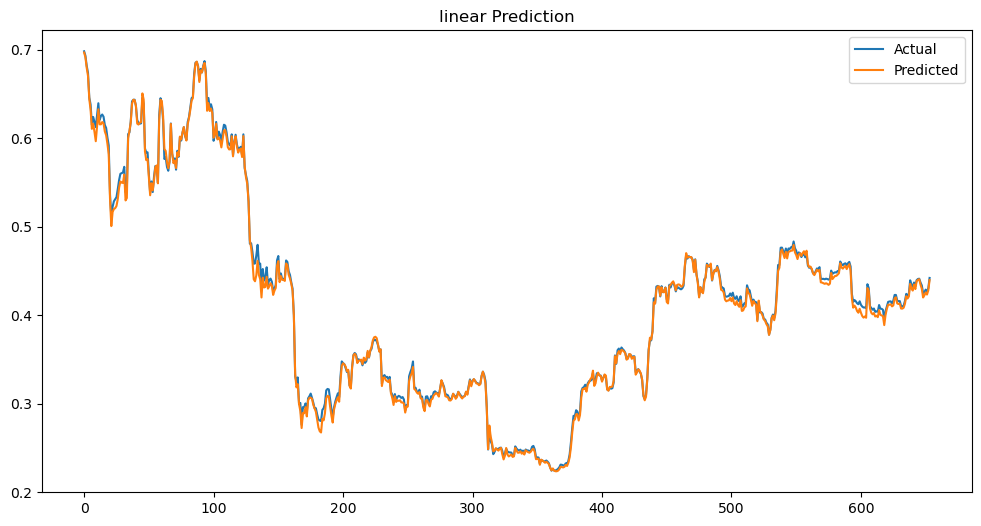

(0.9999552589670228,
 0.9985260566159077,
 2.0107705431419943e-05,
 0.004484161619680979)

In [23]:
polyreg_df(df_data, input_var, method='linear')

[r2_score] train : 0.998160102336741 / test : 0.9904377010554265
[MSE] : 0.00013
[RMSE] : 0.01142


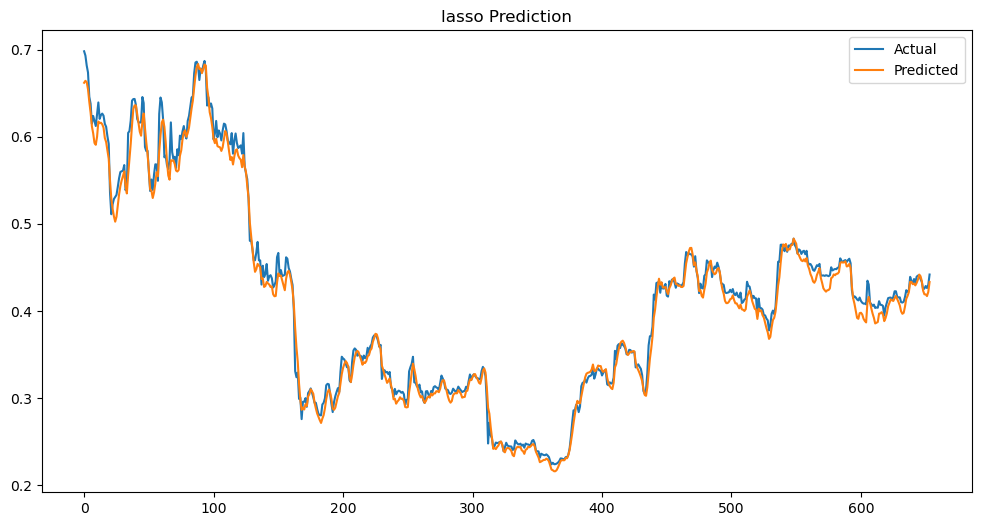

(0.998160102336741,
 0.9904377010554265,
 0.0001304499836966725,
 0.01142147029487327)

In [24]:
polyreg_df(df_data, input_var, method='lasso', alpha=0.001)

[r2_score] train : 0.9999491925423424 / test : 0.9985540438519366
[MSE] : 0.00002
[RMSE] : 0.00444


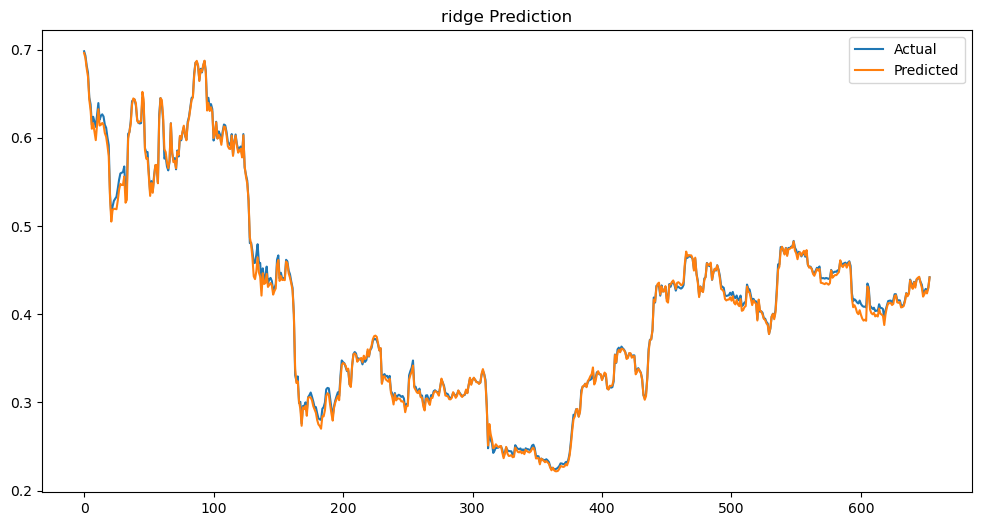

(0.9999491925423424,
 0.9985540438519366,
 1.972590033362418e-05,
 0.004441384956702603)

In [25]:
polyreg_df(df_data, input_var, method='ridge', alpha=0.001)

[ridge / alpha : 0.001]
[r2_score] train : 0.9999492878470863 / test : 0.9985242633818399
[MSE] : 0.00002
[RMSE] : 0.00451


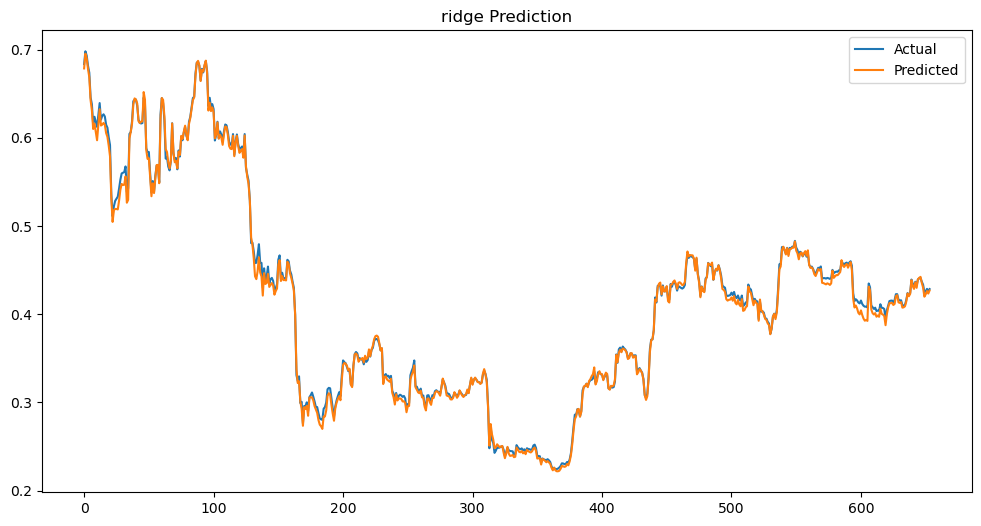

[ridge / alpha : 0.01]
[r2_score] train : 0.9999364007474935 / test : 0.997824846964551
[MSE] : 0.00003
[RMSE] : 0.00547


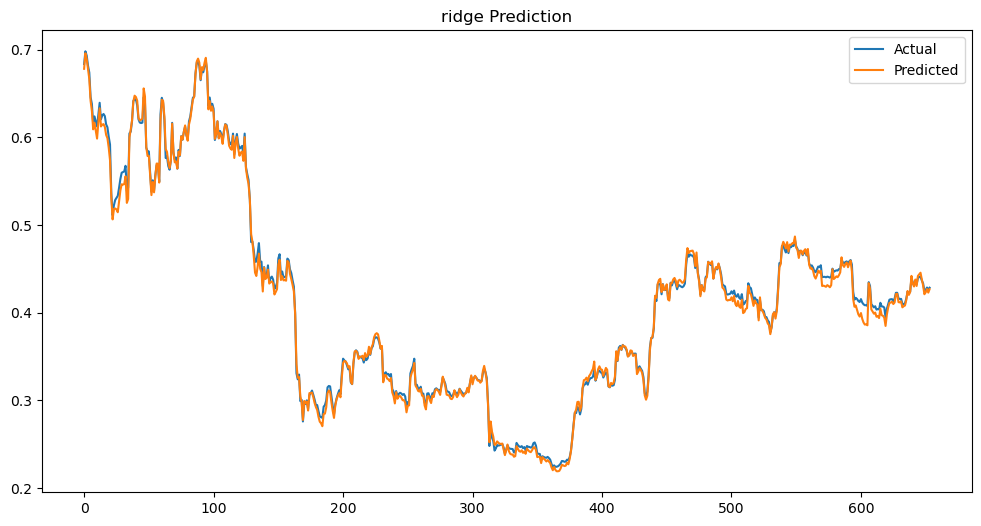

[ridge / alpha : 0.1]
[r2_score] train : 0.9998986762636582 / test : 0.9954422851683509
[MSE] : 0.00006
[RMSE] : 0.00792


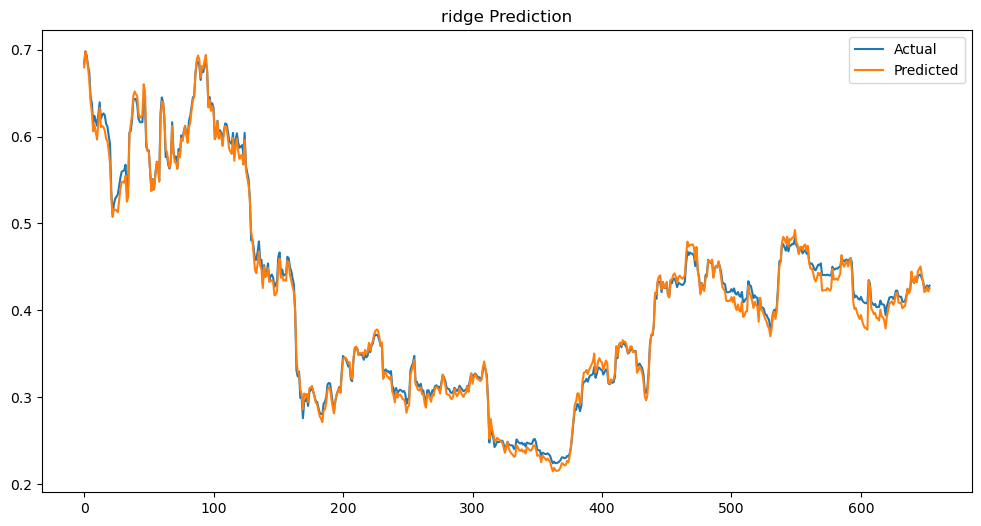

[ridge / alpha : 1]
[r2_score] train : 0.9996954130058806 / test : 0.9841361380697157
[MSE] : 0.00022
[RMSE] : 0.01477


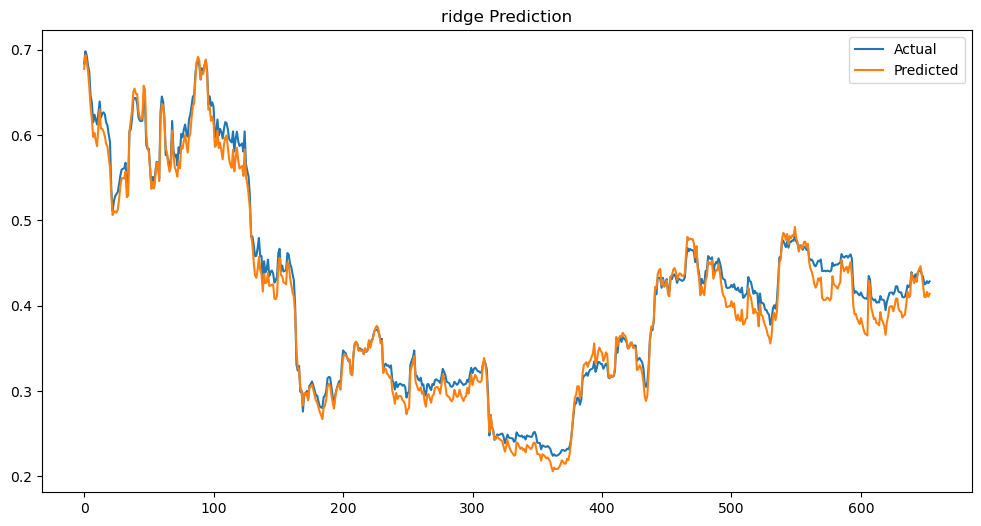

[ridge / alpha : 10]
[r2_score] train : 0.9984809405420761 / test : 0.9045870484755293
[MSE] : 0.00131
[RMSE] : 0.03622


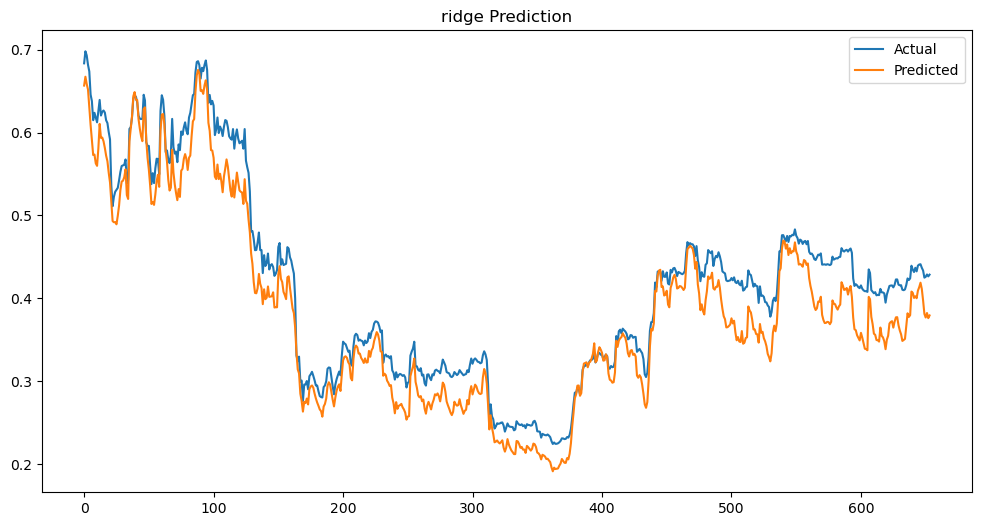

[ridge / alpha : 100]
[r2_score] train : 0.993955069012496 / test : 0.6757664283463382
[MSE] : 0.00446
[RMSE] : 0.06678


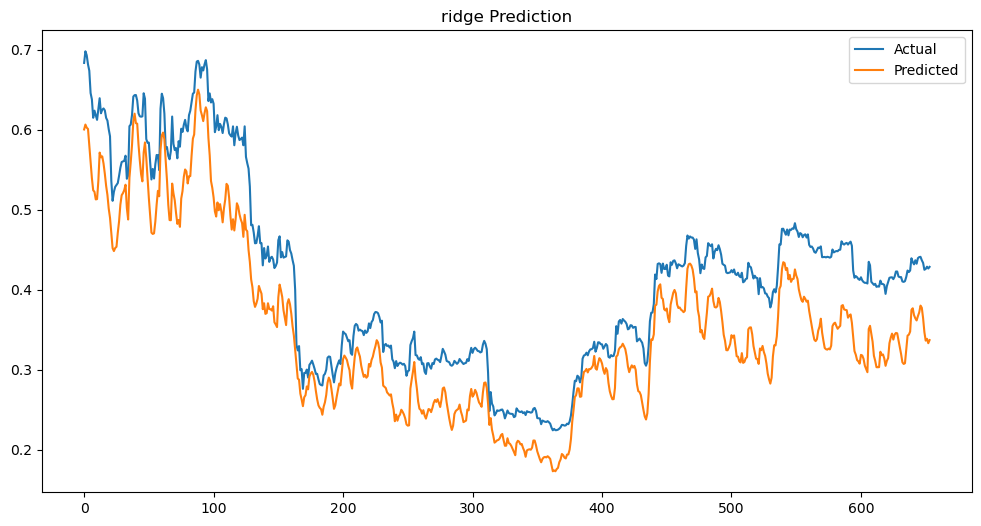

[lasso / alpha : 0.001]
[r2_score] train : 0.998165634335462 / test : 0.9904073255149091
[MSE] : 0.00013
[RMSE] : 0.01149


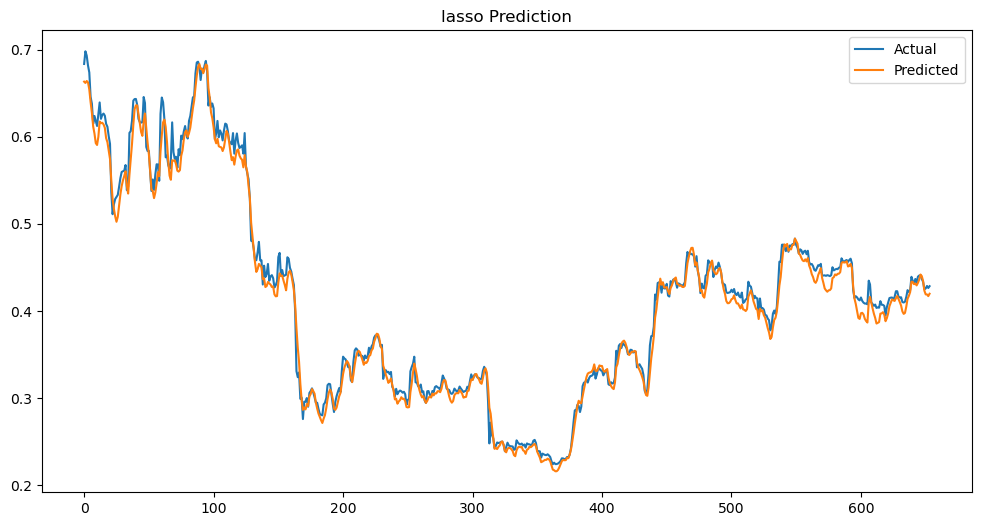

[lasso / alpha : 0.01]
[r2_score] train : 0.9781993761362835 / test : 0.9354664453357726
[MSE] : 0.00089
[RMSE] : 0.02979


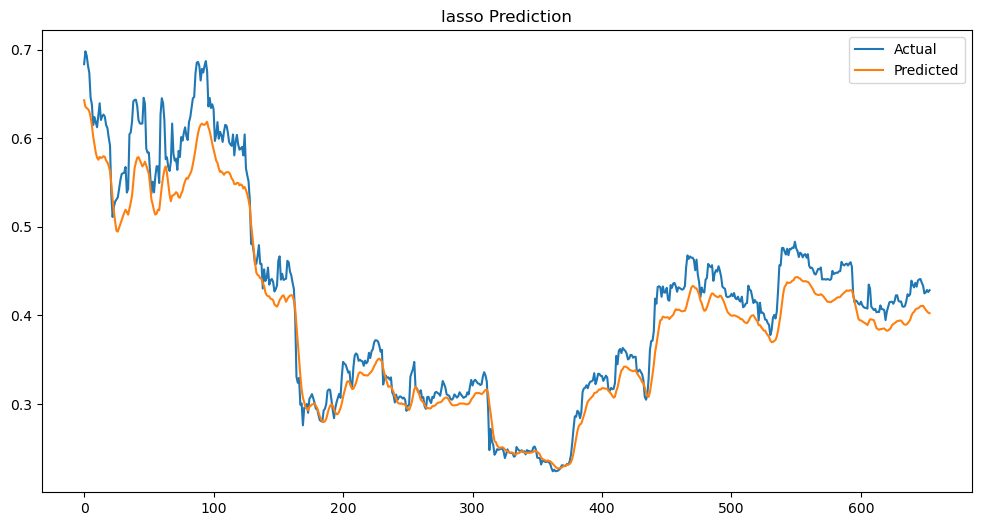

[lasso / alpha : 0.1]
[r2_score] train : 0.0 / test : -2.4773793659459815
[MSE] : 0.04782
[RMSE] : 0.21869


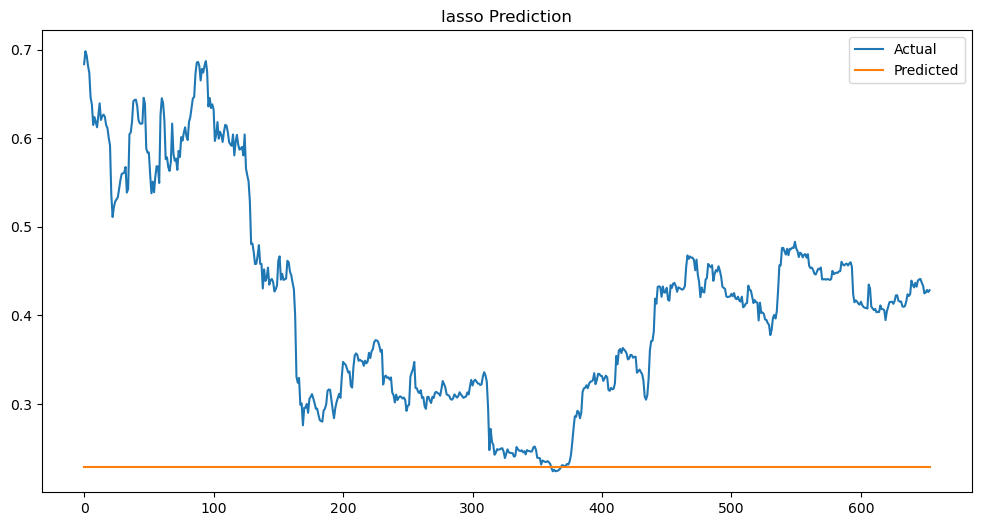

[lasso / alpha : 1]
[r2_score] train : 0.0 / test : -2.4773793659459815
[MSE] : 0.04782
[RMSE] : 0.21869


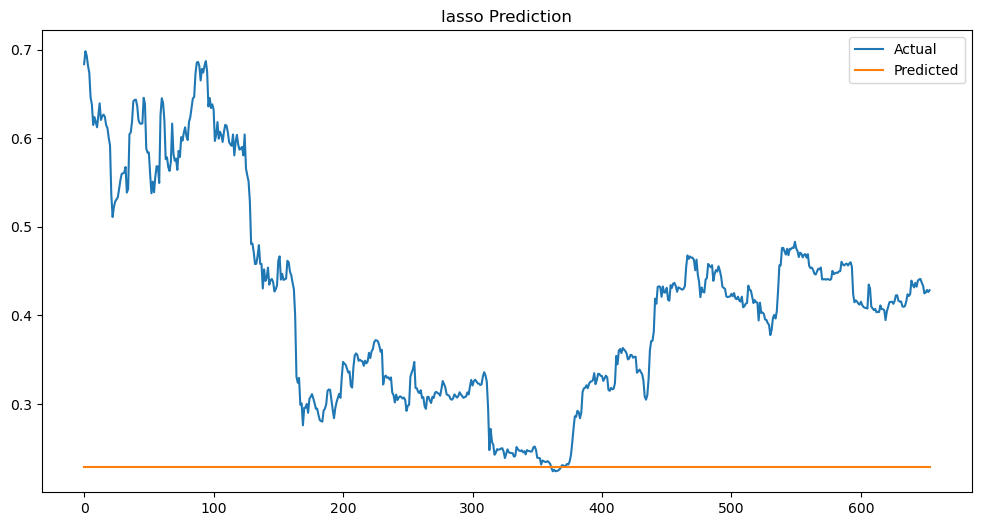

[lasso / alpha : 10]
[r2_score] train : 0.0 / test : -2.4773793659459815
[MSE] : 0.04782
[RMSE] : 0.21869


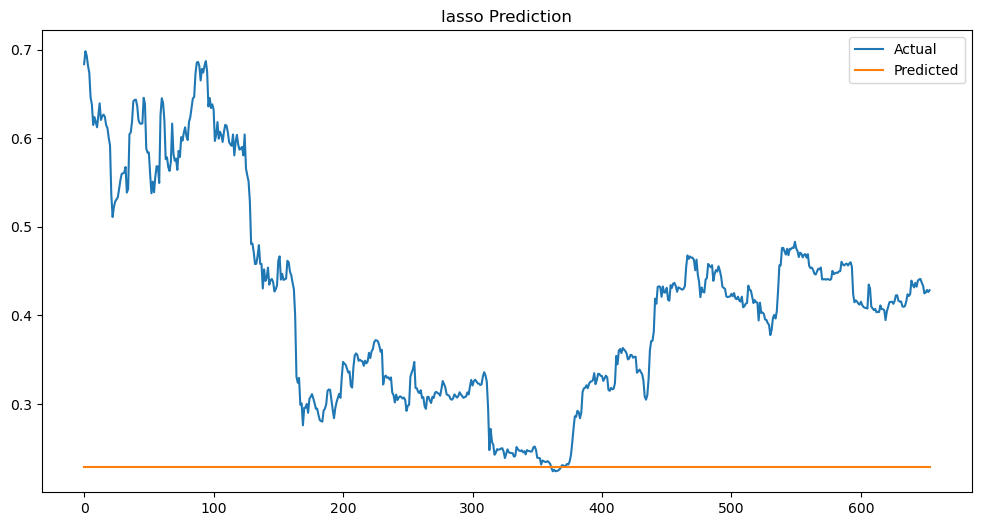

[lasso / alpha : 100]
[r2_score] train : 0.0 / test : -2.4773793659459815
[MSE] : 0.04782
[RMSE] : 0.21869


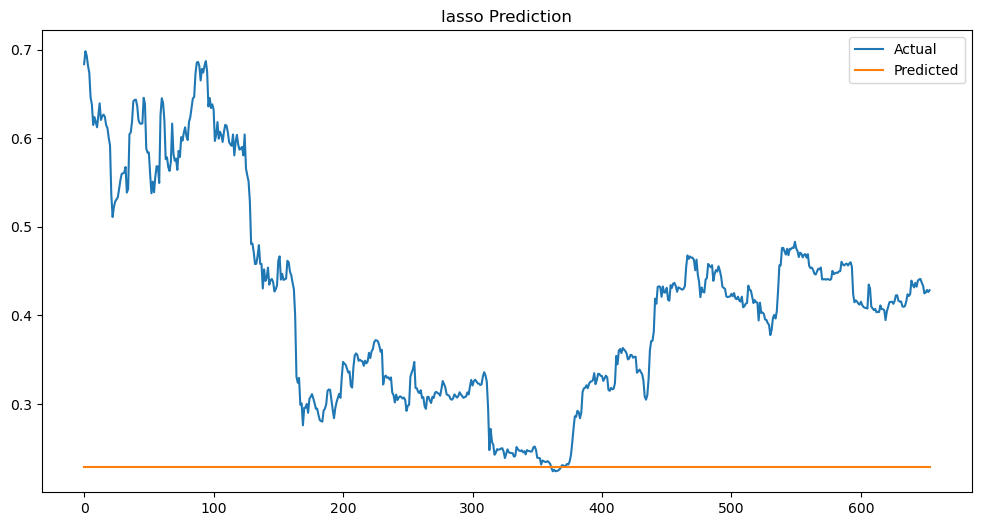

In [10]:
alphas=[0.001, 0.01, 0.1, 1, 10, 100]
methods=['ridge', 'lasso']

for i in methods:
    for j in alphas:
        print(f'[{i} / alpha : {j}]')        
        polyreg_df(df_data, input_var, method=i, alpha=j)